In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
from PIL import Image
from mpl_toolkits.axes_grid1 import ImageGrid
import ipywidgets as widgets
import numpy as np
from utils import Timer, CUDATimer, ntuple, mnistplot
from typing import Optional, Union, Tuple, TypeVar

import taichi as ti
import taichi.math as tm

device = torch.device('cuda')


[Taichi] version 1.5.0, llvm 15.0.4, commit 7b885c28, linux, python 3.10.10


[I 04/13/23 16:54:22.747 40737] [shell.py:_shell_pop_print@23] Graphical python shell detected, using wrapped sys.stdout


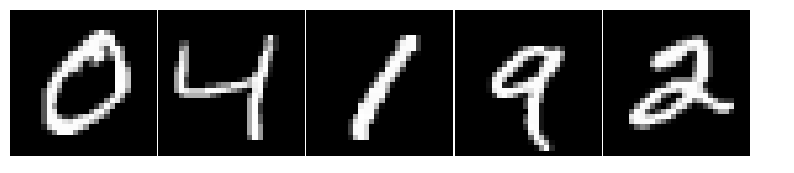

Elapsed: 668.11 ms


In [58]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    # torchvision.transforms.Normalize((0.1307,), (0.3081,)),
])

trainset = torchvision.datasets.MNIST(
    '~/.cache', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(
    '~/.cache', train=False, download=True, transform=transform)

x = torch.unsqueeze(torch.concat([trainset[i][0] for i in range(1, 6)]), 0)
with Timer():
    mnistplot(x)

In [60]:
@ti.dataclass
class ConvDims:
    input_size: ti.types.vector(2, ti.i32)
    kernel_size: ti.types.vector(2, ti.i32)
    in_channels: ti.i32
    out_channels: ti.i32
    padding: ti.types.vector(4, ti.i32)
    stride: ti.types.vector(2, ti.i32)
    dilation: ti.types.vector(2, ti.i32)
    groups: ti.i32

    def output_size(self):
        insize = [self.input_size[i] + self.padding[2*i+1] + self.padding[2*i]
                  for i in range(2)]
        ksize = [(self.kernel_size[i] - 1) * self.dilation[i] + 1 for i in range(2)]
        return [(insize[i] - ksize[i]) // self.stride[i] + 1 for i in range(2)]


def create_convdims2d(
    input_size: Tuple[int, int],
    kernel_size: Tuple[int, int],
    in_channels: int,
    out_channels: int,
    padding: Union[str, int, Tuple[int, int, int, int]] = 0,
    stride: Union[int, Tuple[int, int]] = 1,
    dilation: Union[int, Tuple[int, int]] = 1,
    groups: int = 1
):
    stride = ntuple(stride, 2)
    dilation = ntuple(dilation, 2)

    if isinstance(padding, str):
        assert padding in {'same'}, 'padding = \'{padding}\' is not a valid argument.'
        if padding == 'same':
            padding = [0, 0, 0, 0]
            for d, k, i in zip(dilation, kernel_size,
                               range(len(kernel_size))):
                total_padding = d * (k - 1)
                left_pad = total_padding // 2
                padding[2*i] = left_pad
                padding[2*i+1] = total_padding - left_pad

    padding = ntuple(padding, 4)

    return ConvDims(
        input_size=input_size,
        kernel_size=kernel_size,
        in_channels=in_channels,
        out_channels=out_channels,
        padding=padding,
        stride=stride,
        dilation=dilation,
        groups=groups
    )


In [ ]:


@ti.kernel
def maxplus_fw_kernel_v1(
    y: ti.types.ndarray(ndim=5), # [B,G,Cy,Hy,Wy]
    hits: ti.types.ndarray(dtype=ti.i32, ndim=5), # [B,G,Cx,Hx,Wx]
    x: ti.types.ndarray(ndim=5), # [B,G,Cx,Hx,Wx]
    w: ti.types.ndarray(ndim=4), # [G,Cout,Cin,Hw,Ww]
    cdims: ConvDims
):
    pass